* L'arborescence du projet doit etre le suivant :
   
    - LU3IN013/
        - fichierSerialiser/
            - serie1
            ...
            
        - base_de_donner/
            - serie1/
                - 01/
                    - episodes1.txt
                      ...
                  ...
              ...

        - projet/
            - preTraitement.py
            - utils.py
            - save.py
            - classifiers.py
            - scrapNplot.py

        - jupyter.ipynb
   

In [2]:
# Importation de nos librairie :
# La ligne suivante permet de préciser le chemin 
import sys
sys.path.append('./')   

#importation de la librairie projet
import projet 

# Importation des fonctions de pretraitement
from projet import preTraitement as pt

# importation des fonctions de serialisation de fichier
from projet import save as sv

# importation de fonctions utils
from projet import utils as ut

# importation des biblioteques de classifieurs
from projet import classifiers as cl

 

In [3]:
# commande TRES utile pour recharger automatiquement le code que vous modifiez dans les modules
%load_ext autoreload
%autoreload 2

In [15]:
pp,vv,kk = pt.extractionSeries("./test2")

545___The_Flash
the flash 
the flash 


In [ ]:
# si on veut convertir l'ensemble des sous titres pour le tfidf
resultat = []
for serie in liste:
    resultat.append(ut.reconstitue_serie_tdidf(serie))

In [29]:
# si on veut convertir une seul serie
res = ut.reconstitue_serie_tdidf(pp[0])
res

mb hear bomb came star labs right yes trying disconnect wired directly memory circuits bomb removed properly detonate excuse detonate allen hell going fosnight alpha exactly seems robot robot yeah gears levers built like ringer washer alpha built like woman idea listen come back star labs right know human trust right okay thanks fosnight yeah sure humans strange creatures learn puzzle way greatest gift universe offer life yet seem complain argue fight barry paralyzes nervous system make us hurt alpha wanna reconstruct circuits take back make machine machine alive woman like hardly think alpha make way make feel think respond discuss back lab dr rossick going listen alpha expensive equipment rather back one piece walk away push button nothing handful nuts bolts run stop let get inside questioning residual effects paralysis wear hour find alpha omega good let introduce next generation android series omega faster stronger smarter lacks annoying habit making decisions powers protest omega 

In [31]:
import copy

b,a = cl.TFIDF(res)

for i in a :
    if b[i].mean() < 0.025 :
        b.pop(i)
        continue
    if b[i].mean() > 0.075 :
        b.pop(i)
    
b.mean()

allen       0.037843
alpha       0.027050
anything    0.028491
back        0.053812
call        0.027155
              ...   
want        0.049277
way         0.037184
work        0.029994
would       0.032603
yes         0.031415
Length: 64, dtype: float64

<AxesSubplot:>

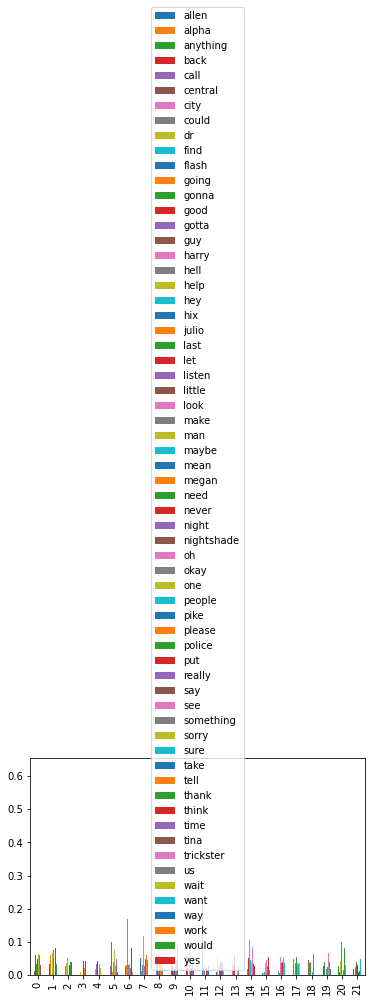

In [32]:
b.plot.bar()

In [34]:
sv.sauvegardeFichier("./fichierSerialiser/fichier3",pp)
liste = sv.lectureFichier("./fichierSerialiser/fichier3")
liste

er',
    'good',
    'gold',
    'right',
    'last',
    'time',
    'okay',
    'next',
    'time',
    'book',
    'regret',
    'anytime',
    'need',
    'anything',
    'give',
    'call',
    'thing',
    'goes',
    'honey',
    'friend',
    'barry',
    'friend',
    'mine',
    'ciao',
    'idea',
    'keep',
    'new',
    'dances',
    'looks',
    'like',
    'fun',
    'come',
    'well',
    'actually',
    'good',
    'like',
    'learn',
    'professional',
    'dancer',
    'never',
    'danced',
    'help',
    'homeless',
    'kidding',
    'come',
    'let',
    'go',
    'move',
    'go',
    'move',
    'way',
    'alpha',
    'trouble',
    'right',
    'time',
    'come',
    'home',
    'going',
    'stay',
    'none',
    'business',
    'hey',
    'buddy',
    'happen',
    'cop',
    'want',
    'stay',
    'healthy',
    'back',
    'make',
    'difficult',
    'want',
    'go',
    'come',
    'hey',
    'shoot',
    'telling',
    'squat',
    'national